In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
import wandb 
import os

# Downloading file from Wandb 

In [2]:
run = wandb.init(project="risk_credit", job_type="EDA")

wandb: Currently logged in as: valoptauhoa (valoptauhoa-national-economics-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
WANDB_API_KEY=os.environ.get('1d620fa1eff54f2f0ba01b14c81969f4ce70bd6c')

In [4]:
!wandb login --relogin 1d620fa1eff54f2f0ba01b14c81969f4ce70bd6c

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PC\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [5]:
wandb.init(project="risk_credit", job_type="download-dataset")

artifact = wandb.use_artifact('EDA_data.csv:latest', type='EDA')

dataset_dir = artifact.download()

wandb.finish()

wandb:   1 of 1 files downloaded.  


# I. Importing dataset 

In [6]:
file_path = os.path.join(dataset_dir, "diabetes_binary_health_indicators_BRFSS2015.csv")
df = pd.read_csv(file_path)

# II. Preprocessing

In [7]:
X = df.drop('Diabetes_binary', axis = 1)
y = df['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## 1. Missing Values Detection

In [8]:
def detect_missing_values(df):
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent
    })
    return missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

In [9]:
print(detect_missing_values(X_train))
print(detect_missing_values(X_test))

Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


## 2. Outliers Clipping

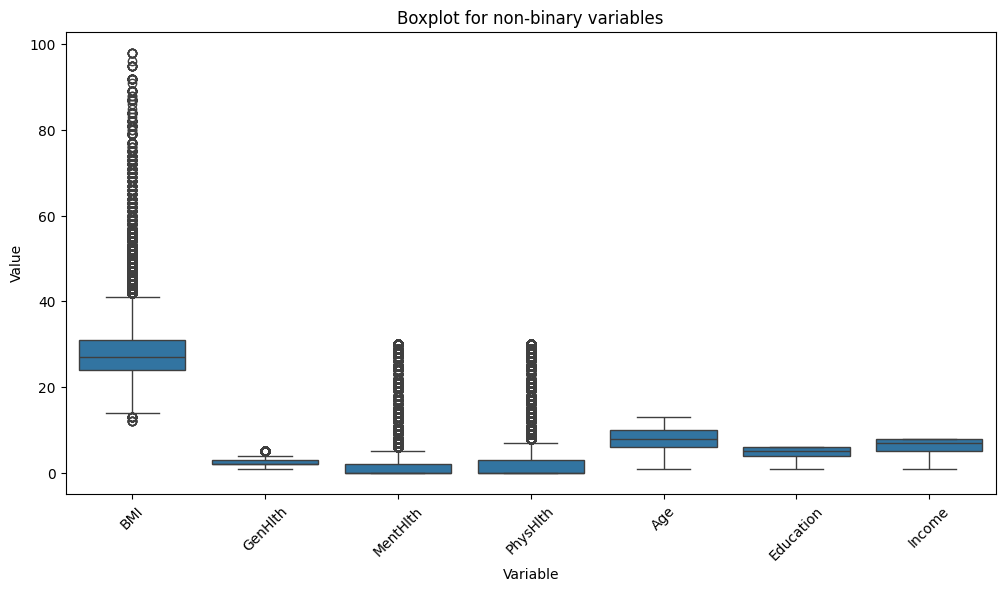

In [10]:
non_binary_columns = [col for col in X_train.columns if X_train[col].nunique() > 2]

df_long = X_train[non_binary_columns].melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Value', data=df_long)
plt.xticks(rotation=45)
plt.title('Boxplot for non-binary variables')
plt.show()

From what i can see, there are a lot of outliers in columns BMI, PhysHlth, MenHlth, GenHlth. From this moment, we approach this problem with our most common method, which is clipping

In [11]:
q1 = X_train[['BMI', 'PhysHlth', 'MentHlth', 'GenHlth']].quantile(0.25)
q3 = X_train[['BMI', 'PhysHlth', 'MentHlth', 'GenHlth']].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for col in ['BMI', 'PhysHlth', 'MentHlth', 'GenHlth']:
    X_train[col] = X_train[col].clip(lower=lower_bound[col], upper=upper_bound[col])              
    X_test[col] = X_test[col].clip(lower=lower_bound[col], upper=upper_bound[col])

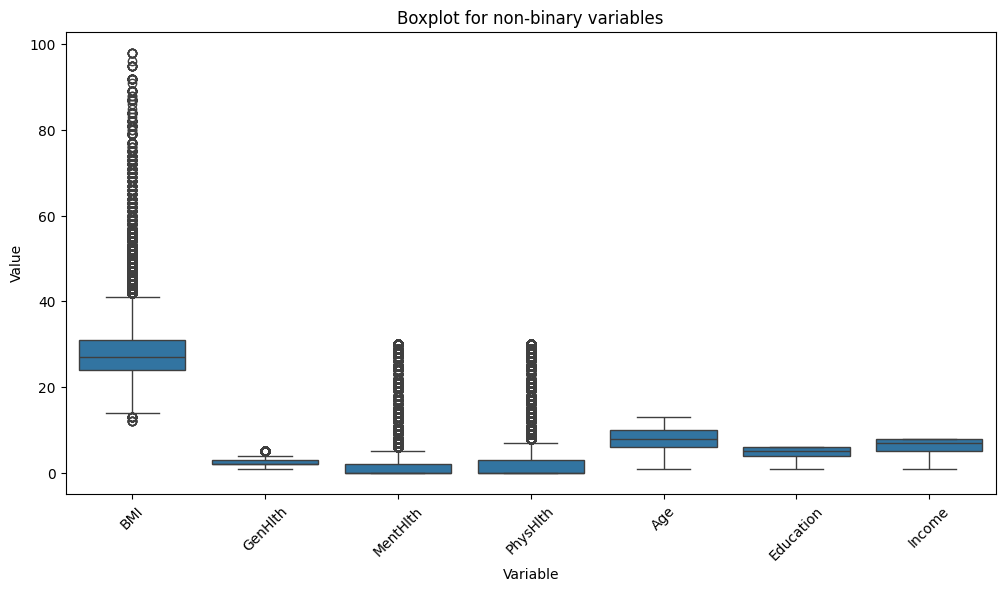

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Value', data=df_long)
plt.xticks(rotation=45)
plt.title('Boxplot for non-binary variables')
plt.show()

# Uploading file to Wandb 

In [13]:
X_train_file = os.path.join(dataset_dir, "X_train.csv")
X_test_file = os.path.join(dataset_dir, "X_test.csv")
y_train_file = os.path.join(dataset_dir, "y_train.csv")
y_test_file = os.path.join(dataset_dir, "y_test.csv")

X_train.to_csv(X_train_file, index=False)
X_test.to_csv(X_test_file, index=False)
y_train.to_csv(y_train_file, index=False)
y_test.to_csv(y_test_file, index=False)

In [14]:
run = wandb.init(project="risk_credit", job_type="EDA")

In [15]:
def upload_artifact(artifact_name, file_path, artifact_type="Preprocessing", artifact_description="Preprocessed data"):
    artifact = wandb.Artifact(
        name=artifact_name,
        type=artifact_type,
        description=artifact_description
    )
    artifact.add_file(file_path)
    wandb.log_artifact(artifact)

In [16]:
upload_artifact("X_train.csv", X_train_file)
upload_artifact("X_test.csv", X_test_file)
upload_artifact("y_train.csv", y_train_file)
upload_artifact("y_test.csv", y_test_file)

In [17]:
wandb.finish()